In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import joblib
import torch
from tqdm import tqdm

from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED
from lightglue.utils import rbd

from datasets import Trainset, Testset
from utils import average_euclidean_distance, visualize

D:\windows_envs\rgb_ir_mathing\Lib\site-packages\lightglue\lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
# Load thermal patches
with open("datasets/uav.pkl", "rb") as f:
    uav_data = joblib.load(f)
thermal_patches = uav_data['anchor']  
centers = uav_data['center']

In [3]:
# set up seeds list to repeat experiments and other constants
seeds = [52,42,95, 123, 985]
crop_size = 1536
patch_size = 512
num_samples = 5000 # how many samples to generate and test.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image to lightglue input casting with normalization.
img2torch = lambda x: torch.tensor(x, dtype=torch.float32).permute(2, 0, 1) / 255.0
target = np.array([-1,-1])

In [4]:
# or DISK+LightGlue, ALIKED+LightGlue or SIFT+LightGlue 
# multiple extractors can be tested.

extractors = [
    SuperPoint(max_num_keypoints=4096).eval(), 
    DISK(max_num_keypoints = 4096).eval(),
    #SIFT(max_num_keypoints = 2048).eval(), # If it can't produce enough keypoints, code lightglue fails.
    ALIKED(max_num_keypoints = 4096).eval(),
]

matchers = [
     LightGlue(features='superpoint',depth_confidence=-1, width_confidence=-1, ).eval(),
     LightGlue(features='disk',depth_confidence=-1, width_confidence=-1, ).eval(),
     #LightGlue(features='sift',depth_confidence=-1, width_confidence=-1, ).eval(), # If it can't produce enough keypoints, code lightglue fails.
     LightGlue(features='aliked',depth_confidence=-1, width_confidence=-1, ).eval(),
]

SuperPoint Testset Experiments: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [18:29<00:00, 221.85s/it]




    Extractor: SuperPoint
    Metrics Across All Experiments Across All Patches:
        
        Average trainset error (all predictions): 703.96 pixels
        Average testset error  (all predictions): 777.55 pixels
    
        Trainset center point estimation fail count: 10530 out of 25000 estimations
        Testset center point estimation fail count: 12278 out of 25000 estimations
    
        Average trainset error (successful predictions): 398.68 pixels (14470/25000)
        Average testset error  (successful predictions): 436.49 pixels (12722/25000)
    
	Visualize Trainset: 


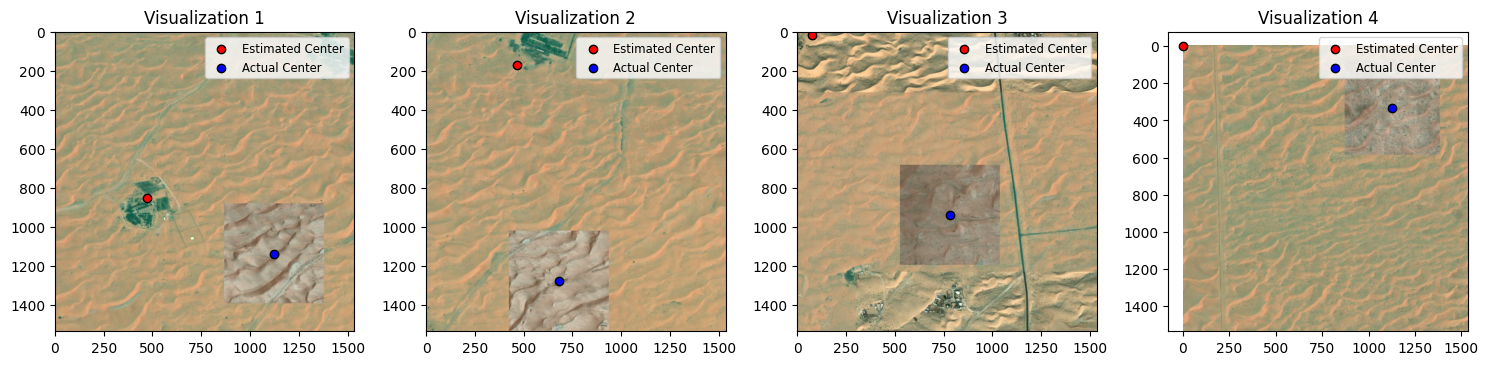

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

	Visualize Testset: 


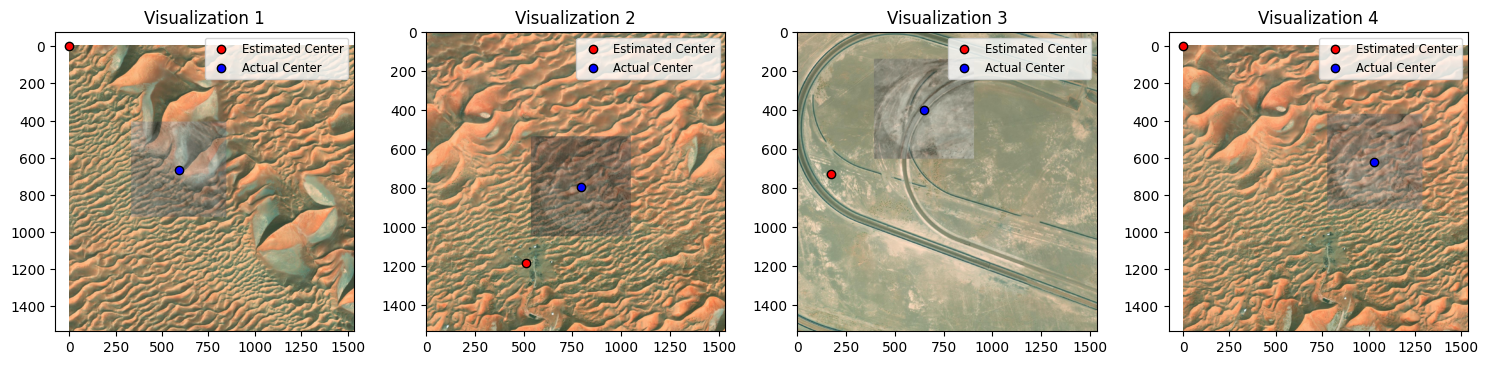

DISK Testset Experiments: 100%|███████████████████████████████████████████████████████████████████████████| 5/5 [40:35<00:00, 487.19s/it]




    Extractor: DISK
    Metrics Across All Experiments Across All Patches:
        
        Average trainset error (all predictions): 535.87 pixels
        Average testset error  (all predictions): 638.25 pixels
    
        Trainset center point estimation fail count: 3703 out of 25000 estimations
        Testset center point estimation fail count: 6110 out of 25000 estimations
    
        Average trainset error (successful predictions): 434.39 pixels (21297/25000)
        Average testset error  (successful predictions): 482.44 pixels (18890/25000)
    
	Visualize Trainset: 


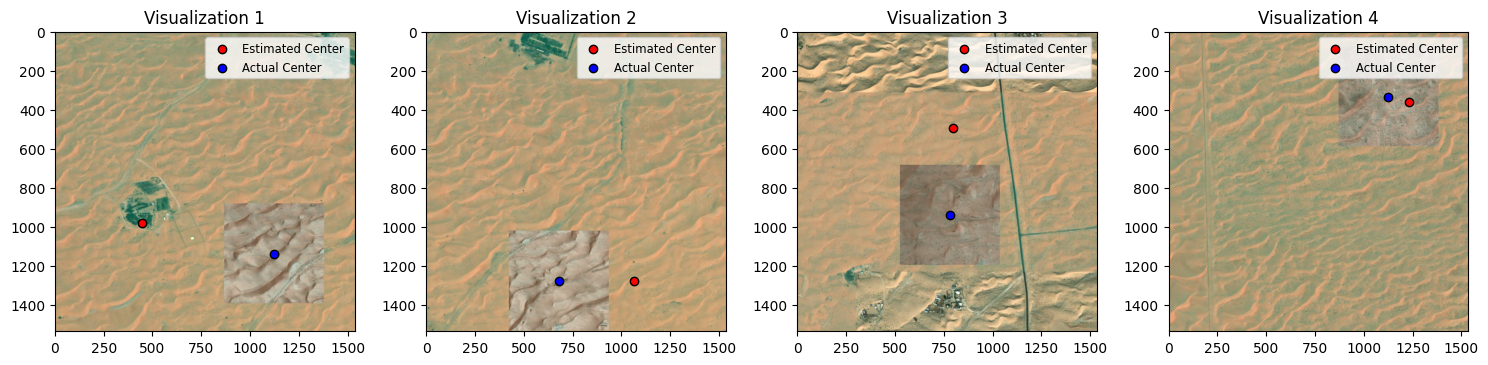

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

	Visualize Testset: 


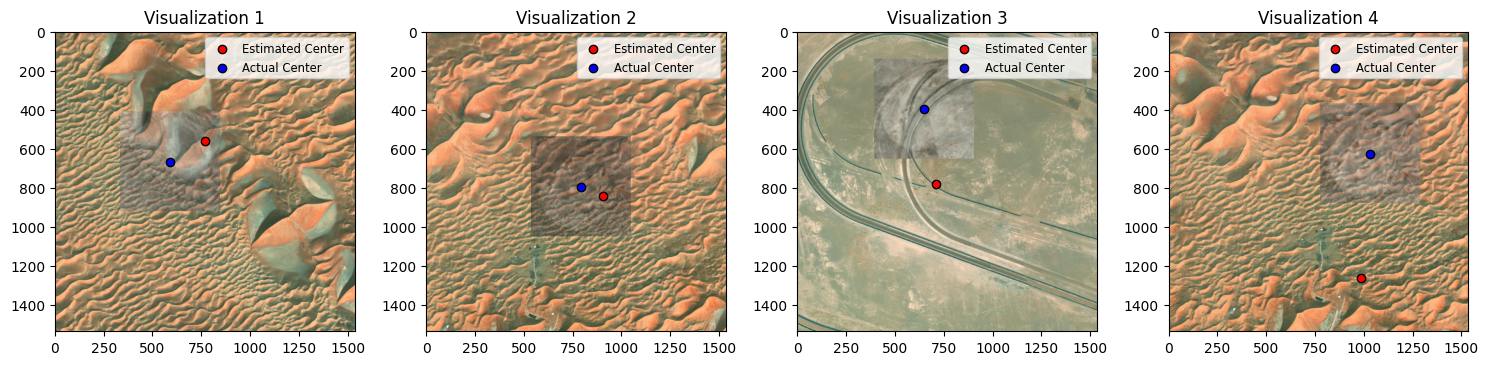

ALIKED Testset Experiments: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [22:14<00:00, 266.81s/it]




    Extractor: ALIKED
    Metrics Across All Experiments Across All Patches:
        
        Average trainset error (all predictions): 353.78 pixels
        Average testset error  (all predictions): 504.85 pixels
    
        Trainset center point estimation fail count: 660 out of 25000 estimations
        Testset center point estimation fail count: 746 out of 25000 estimations
    
        Average trainset error (successful predictions): 330.81 pixels (24340/25000)
        Average testset error  (successful predictions): 485.20 pixels (24254/25000)
    
	Visualize Trainset: 


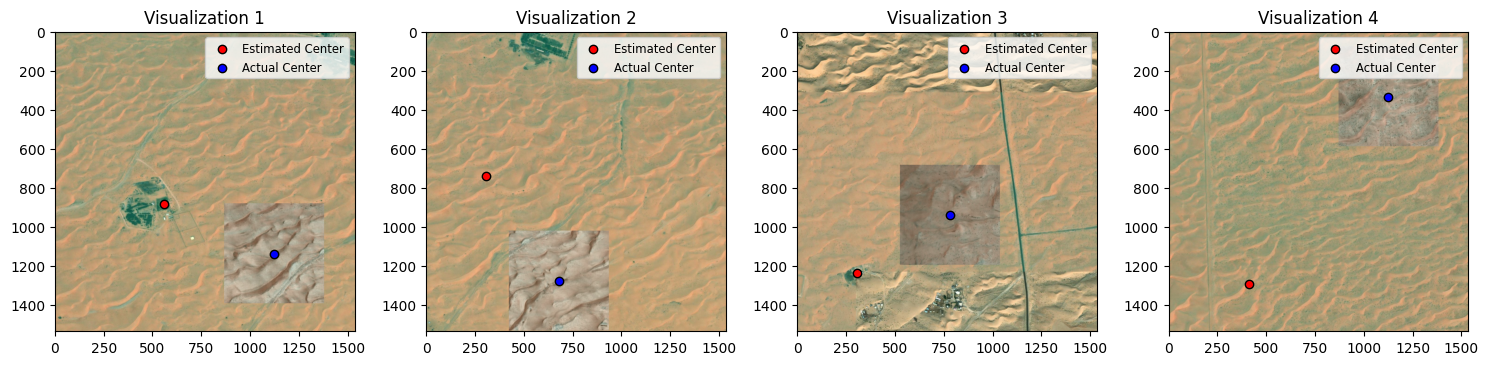

	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 

	Visualize Testset: 


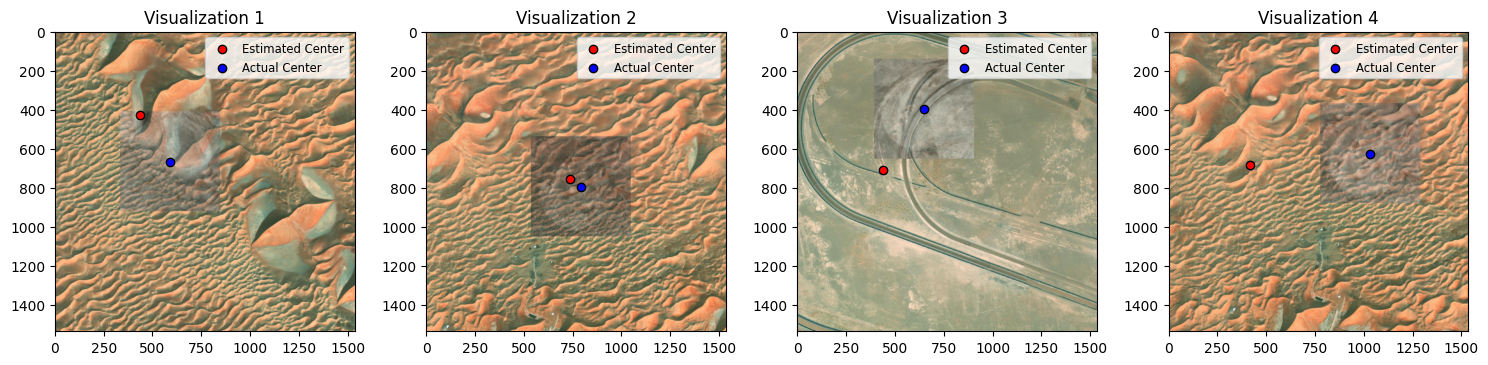

In [5]:
for extractor, matcher in zip(extractors, matchers):
    # Store estimations in lists per extractor & matcher pipeline:
    trainset_estimated_centers = []
    trainset_ground_truth_centers = []
    testset_estimated_centers = []
    testset_ground_truth_centers = []

    extractor_name = extractor.__class__.__name__
    extractor = extractor.to(device)
    matcher = matcher.to(device)
    
    
    # Trainset Experiments performed per seed. all estimated centers and actual centers are stored, finally reported. 
    for seed in tqdm(seeds,desc= extractor_name + " Trainset Experiments: "): 
        # set random seed 
        rng = np.random.default_rng(seed)
        
        # generate datasets on the fly
        # since base model doesn't need transformations, we will only use datasets and not the associated dataloaders. 
        trainset = Trainset(rgb_base_path="datasets/rgb_zone1.png", thermal_base_path="datasets/thermal_zone1.png", num_samples=num_samples, rng = rng, crop_size=crop_size, patch_size=patch_size)
    
        # Estimate centers and store it along with ground truth centers for trainset
        for sample in trainset:
            # get pair of images
            rgb_crop = img2torch(sample["rgb_crop"]).to(device)
            thermal_patch = img2torch(sample["thermal_patch"]).to(device)
            
            # lightglue inference only supports single batch operations
            # extract local features
            feats_rgb_crop = extractor.extract(rgb_crop)  # auto-resize the image, disable with resize=None
            feats_thermal_patch = extractor.extract(thermal_patch)
            
            # match the features
            matches_crop_patch = matcher({'image0': feats_rgb_crop, 'image1': feats_thermal_patch})
            feats_rgb_crop, feats_thermal_patch, matches_crop_patch = [rbd(x) for x in [feats_rgb_crop, feats_thermal_patch, matches_crop_patch]]  # remove batch dimension
            matches = matches_crop_patch['matches']  # indices with shape (K,2)
            points_rgb_crop = feats_rgb_crop['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points_thermal_patch = feats_thermal_patch['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)
    
            # Use average of matching keypoints as the estimated center.
            if points_rgb_crop.nelement() > 0:
                estimated_center = points_rgb_crop.mean(axis=0)
                trainset_estimated_centers.append(estimated_center.cpu().numpy())
            else:
                trainset_estimated_centers.append(target) # Could not make a center prediction, punish. (-1,-1) so that we could count it later.
    
            # add ground truth
            trainset_ground_truth_centers.append(sample["patch_center_crop"])

    # Test Experiments performed per seed. all estimated centers and actual centers are stored, finally reported. 
    for seed in tqdm(seeds,desc= extractor_name + " Testset Experiments: "): 
        rng = np.random.default_rng(seed)
        testset = Testset(rgb_base_path="datasets/rgb_zone2.png", thermal_patches= thermal_patches, centers= centers, num_samples=num_samples, rng=rng, crop_size=crop_size, patch_size=patch_size)
    
        # Estimate centers and store it along with ground truth centers for trainset
        for sample in testset:
            # get pair of images
            rgb_crop = img2torch(sample["rgb_crop"]).to(device)
            thermal_patch = img2torch(sample["thermal_patch"]).to(device)
            
            # lightglue inference only supports single batch operations
            # extract local features
            feats_rgb_crop = extractor.extract(rgb_crop)  # auto-resize the image, disable with resize=None
            feats_thermal_patch = extractor.extract(thermal_patch)
            
            # match the features
            matches_crop_patch = matcher({'image0': feats_rgb_crop, 'image1': feats_thermal_patch})
            feats_rgb_crop, feats_thermal_patch, matches_crop_patch = [rbd(x) for x in [feats_rgb_crop, feats_thermal_patch, matches_crop_patch]]  # remove batch dimension
            matches = matches_crop_patch['matches']  # indices with shape (K,2)
            points_rgb_crop = feats_rgb_crop['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
            points_thermal_patch = feats_thermal_patch['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)
    
            # Use average of matching keypoints as the estimated center.
            if points_rgb_crop.nelement() > 0:
                estimated_center = points_rgb_crop.mean(axis=0)
                testset_estimated_centers.append(estimated_center.cpu().numpy())
            else:
                testset_estimated_centers.append(target) # Could not make a center prediction, punish. (-1,-1) so that we could count it later.
    
            # add ground truth
            testset_ground_truth_centers.append(sample["patch_center_crop"])

        
    # Calculate all prediction average error.
    trainset_avg_euclidian_distance_error = average_euclidean_distance(trainset_estimated_centers,trainset_ground_truth_centers)
    testset_avg_euclidian_distance_error = average_euclidean_distance(testset_estimated_centers,testset_ground_truth_centers)
    
    # Get prediction fail count.
    trainset_fail_count = np.sum(np.all(np.stack(trainset_estimated_centers) == target,axis=1))
    testset_fail_count = np.sum(np.all(np.stack(testset_estimated_centers) == target,axis=1))
    
    # Get samples predictions could be made
    trainset_indices = np.where(~np.all(np.stack(trainset_estimated_centers) == target, axis=1))[0]
    testset_indices = np.where(~np.all(np.stack(testset_estimated_centers) == target, axis=1))[0]
    
    trainset_avg_succ_euclidian_distance_error = average_euclidean_distance(np.stack(trainset_estimated_centers)[trainset_indices,:],
                                                                            np.asarray(trainset_ground_truth_centers)[trainset_indices,:])
    testset_avg_succ_euclidian_distance_error =  average_euclidean_distance(np.stack(testset_estimated_centers)[testset_indices,:],
                                                                            np.asarray(testset_ground_truth_centers)[testset_indices,:])
    
    print(f"""

    Extractor: {extractor_name}
    Metrics Across All Experiments Across All Patches:
        
        Average trainset error (all predictions): {trainset_avg_euclidian_distance_error:.2f} pixels
        Average testset error  (all predictions): {testset_avg_euclidian_distance_error:.2f} pixels
    
        Trainset center point estimation fail count: {trainset_fail_count} out of {len(trainset_estimated_centers)} estimations
        Testset center point estimation fail count: {testset_fail_count} out of {len(testset_estimated_centers)} estimations
    
        Average trainset error (successful predictions): {trainset_avg_succ_euclidian_distance_error:.2f} pixels ({len(trainset_estimated_centers)-trainset_fail_count}/{len(trainset_estimated_centers)})
        Average testset error  (successful predictions): {testset_avg_succ_euclidian_distance_error:.2f} pixels ({len(testset_estimated_centers)-testset_fail_count}/{len(testset_estimated_centers)})
    """)

    num_visualizations =4  # Change this value as needed. Bigger than num_samples will cause "visualize function" to malfunction.
    print("\tVisualize Trainset: ")
    visualize(trainset[-num_visualizations:],
              estimated_centers=trainset_estimated_centers[-num_visualizations:])
    
    print(f"\t{'-'*220}","\n")
    
    print("\tVisualize Testset: ")
    visualize(testset[-num_visualizations:],
              estimated_centers=testset_estimated_centers[-num_visualizations:])

    # remove old objects from memory
    del extractor, matcher, trainset, testset
    torch.cuda.empty_cache()

